## Content


- **Business Case Introduction**

- **Contexual Word Embeddings**



- **SVD based Methods**




- **Word2Vec Model**
> 1.   CBoW
> 2.   Skip-Gram





- **Training methods available-**
> 1.   Negative Sampling
> 2.   Hierarchical Softmax

- **Gensim library to build Word2Vec from scratch.**

- **Built a search engine**

## With over 50,000 publications and research papers on the corona-virus family till date, it has become difficult to search across and get useful insights for medical practitioners.

As a $ Data Scientist $ at Google, you are tasked with solving this problem with the help of Machine Learning.

[Efficient Estimation of Word Representations in
Vector Space](https://arxiv.org/pdf/1301.3781.pdf)

[GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/pubs/glove.pdf)

#### How can we solve for this problem?
 - Can we match keywords from user queries that are present in abstract?
 - If we do keyword matching, will we be able to understand the user's intent? For e.g: 'origin' and 'discovery'
 - Should we consider the context of the words, then?

## Let us build a search engine using Word Embeddings

#### Datset
- COVID-19 Open Research Dataset, consisting of all publications/research papers related to Covid-19.
- Dataset contains Title, Abstract, DoI among other identifiers.
- To download - https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge


## Let us explore the dataset

#### Importing Necessary Libraries

In [ ]:
!pip install -q langdetect
!gdown 18M7lJHV6Y4pJTsFzDw8_mf2_cQMuFcxE

     |████████████████████████████████| 981 kB 15.6 MB/s 
Downloading...
From: https://drive.google.com/uc?id=1VkNpuudQnlj7g5uUCNPJ4MKxFdDdh7bZ
To: /content/metadata.csv
100% 1.65G/1.65G [00:15<00:00, 107MB/s]


In [ ]:
import spacy
import string
import warnings

import numpy as np
import pandas as pd

from pprint import pprint
from IPython.utils import io
from tqdm.notebook import tqdm
from gensim.models import Word2Vec
from langdetect import DetectorFactory, detect
from IPython.core.display import HTML, display
from IPython.display import Image
from spacy.lang.en.stop_words import STOP_WORDS

warnings.filterwarnings('ignore')
tqdm.pandas()

#### Loading the dataset

In [ ]:
DATA = pd.read_csv("metadata.csv").sample(100000) # taking only 100000 research papers
DATA.reset_index(inplace=True, drop=True)
print(DATA.columns)
DATA.head(2)

Index(['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id',
       'license', 'abstract', 'publish_time', 'authors', 'journal', 'mag_id',
       'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files',
       'url', 's2_id'],
      dtype='object')


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,gnh51fzr,fe177de29f14dd45747a3d17c2468300245b0fb4,PMC,‘I Get High With a Little Help From My Friends...,10.3389/fpsyg.2021.719596,PMC8504457,34646208,cc-by,Psychoactive drugs have been central to many h...,2021-09-24,"Newson, Martha; Khurana, Ragini; Cazorla, Frey...",Front Psychol,NaN,NaN,NaN,document_parses/pdf_json/fe177de29f14dd45747a3...,document_parses/pmc_json/PMC8504457.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8...,NaN
1,wbh06gzb,ab312eb3286e189488707ea7ac8551401a178940,PMC,Arenavirus Stable Signal Peptide Is the Keysto...,10.1128/mbio.02063-14,PMC4217180,25352624,cc-by-nc-sa,The rodent arenavirus glycoprotein complex enc...,2014-10-28,"Bederka, Lydia H.; Bonhomme, Cyrille J.; Ling,...",mBio,NaN,NaN,NaN,document_parses/pdf_json/ab312eb3286e189488707...,document_parses/pmc_json/PMC4217180.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...,NaN


### Among all the features available, we can drill down to using 'Abstract' to create the search engine. Why?
- Abstract gives a complete, yet concise, understanding of the publication's research and findings.

#### Do we have missing data?

In [ ]:
DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          100000 non-null  object 
 1   sha               35242 non-null   object 
 2   source_x          100000 non-null  object 
 3   title             99946 non-null   object 
 4   doi               62094 non-null   object 
 5   pmcid             36827 non-null   object 
 6   pubmed_id         47157 non-null   object 
 7   license           100000 non-null  object 
 8   abstract          77551 non-null   object 
 9   publish_time      99844 non-null   object 
 10  authors           97680 non-null   object 
 11  journal           91699 non-null   object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  45679 non-null   object 
 14  arxiv_id          1420 non-null    object 
 15  pdf_json_files    35242 non-null   object 
 16  pmc_json_files    297

## Approach

For each incoming query, **calculate semantic similarity** with all documents in the dataset and **pick top N publications** from the dataset.



**But, before we start building this out, we will have to process the abstract and represent them as contextual word embeddings.**

### What is the need for representing words as texts?
 - Machine Learning algorithms and Deep Learning Architectures are **capable of processing only numbers**.

### But, we have already learnt to represent words as discrete representations, why learn another technique?
- Discrete representations treat words as completely **independent entities**.
- Cannot capture relationship between words, thus providing **no context**.

### So how do we capture contexts?
- Using **Continous word representations**.
- **Capable** of capturing context of a word, based on **syntactic and semantic similarity**.
- Capture word to word relationships.
- Techniques for representations:
    - Singular Value Decomposition (SVD) based methods
    - Iteration based methods

## What are SVD based methods and how are embeddings generated?
- Key Concepts:
    - SVD theorem says **its always possible to decompose a matrix** $A_{m * n}$ as a product of **$U_{m * m}$, $\Sigma_{m * n}$, $V_{n * n}$**, where $U^TU$ = I and $V^TV$ = I.
    - We **loop over the corpus** and **accumulate word co-occurence counts** in the form of a matrix called 'X'.
    - Perform **SVD on X** to get UΣV$^T$ decomposition.
    - Use **rows of U as the word embeddings** for all words in our dictionary.

#### Let us discuss few choices of generating "X":


{A} Word-Document Matrix:
 - Assumption - **Words that are related will often appear in the same documents and vice versa**.
 - Loop over the corpus and **for each time word i appears in document j**, we add one to entry $X_{ij}$.
 - The X generated is of the size {R$^{|V|×M}$} and it scales with the number of documents.

{B} Co-Occurence Matrix:
 - Similar to Word-Document Matrix, however, the **matrix X contains co-occurrences of words** thereby becoming an **affinity matrix**.
 - X is generating by counting the **number of times each word appears inside a window** of a particular size **around the word of interest**.
 - Calculate this count across all the words in the corpus.

#### SVD with an example:
Corpus contains 3 sentences:
1. "I enjoy flying."
2. "I like NLP."
3. "I like deep learning."

Based on window size of 1, the **count matrix** will be:

## SVD Count Matrix

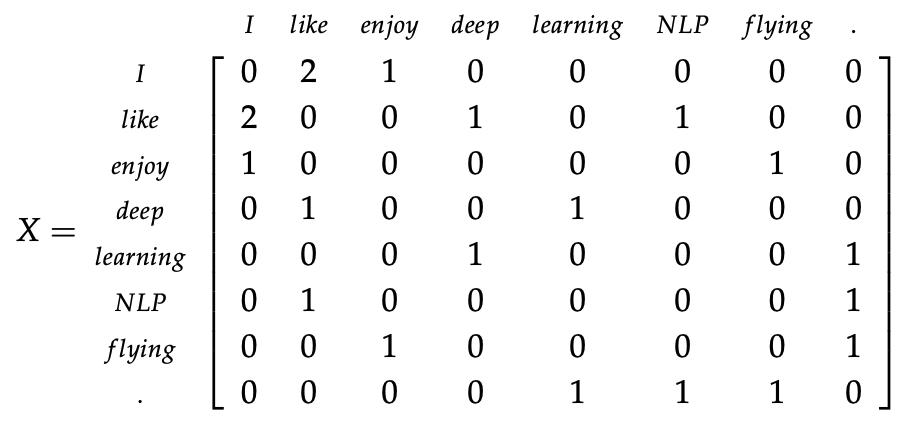

## **Performing SVD** on the Co-Occurence Matrix

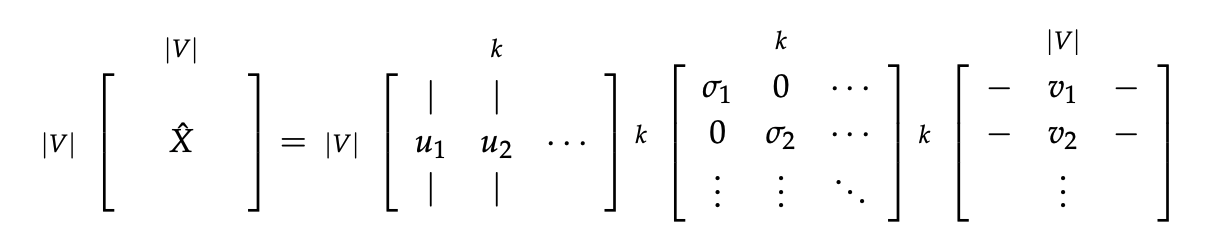




## **Pick an index *k* from U** matrix that will capture **variance** based on desired percentage using


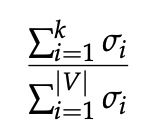

## Finally, the **submatrix $U_{1:|V|, 1:k}$** will form our **word embedding matrix**.

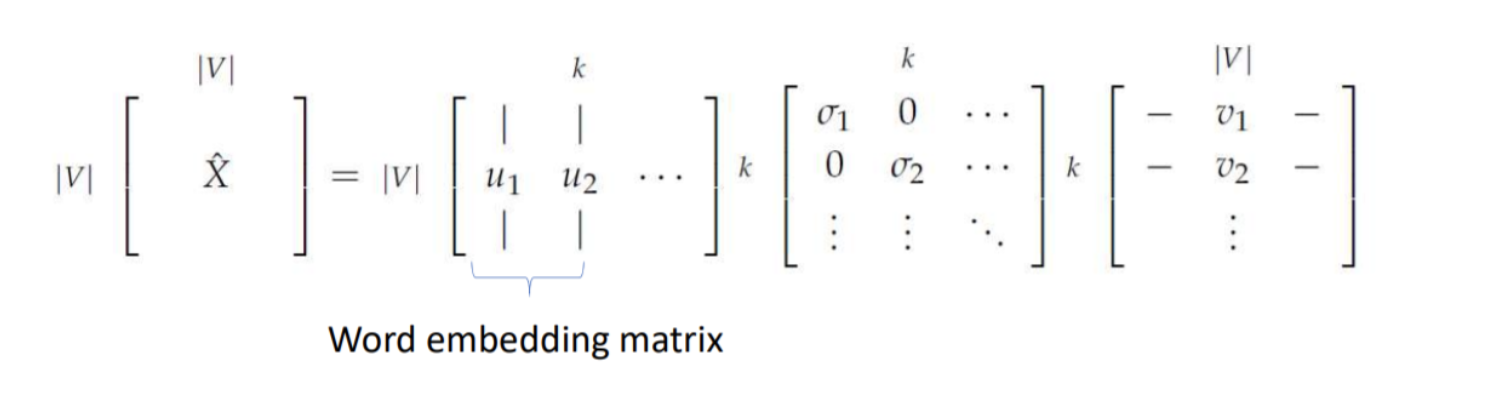

## Can we use SVD for building for our search engine?
No. While SVD based methods give us word vectors that are more than sufficient to encode semantic and syntactic information they are associated with many **dis-advantages**:
  - SVD based methods do not scale well for large matrices. Given the size of our data, it will be **computationally expensive** to perform.
  - The matrix can become **extremely sparse** since most words do not co-occur.

## How do we circumvent the drawbacks of SVD based methods?
 - Instead of computing and storing global information about some huge data, we can build a **model that can encode contextual information** and produce word vectors.
 - One such architecture called the **Word2Vec**, an iterative method, to generate word embeddings.

## What is Word2Vec?
### Word2Vec works with the idea that two words are similar if they share or occur in similar context.


- Word2vec is a **shallow neural network** that is trained to **reconstruct linguistic contexts** of words.
- Word2vec takes in **large corpus of text as input** and **produces a vector** of several hundred dimensions.
- Each **unique word** in the corpus is assigned a **corresponding vector** in the space.
- Word **vectors are positioned in the vector** space such that **words that share common contexts** in the corpus are located **close to one another** in the space.

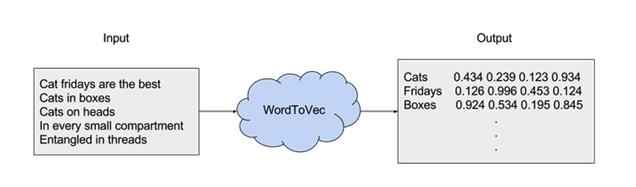

## How does Word2Vec learn word embeddings?
- Word2vec utilizes either of the two model architectures to produce a distributed representation of words:
 - **Continuous Bag-of-Words (CBoW)**
 - **Skip-gram**

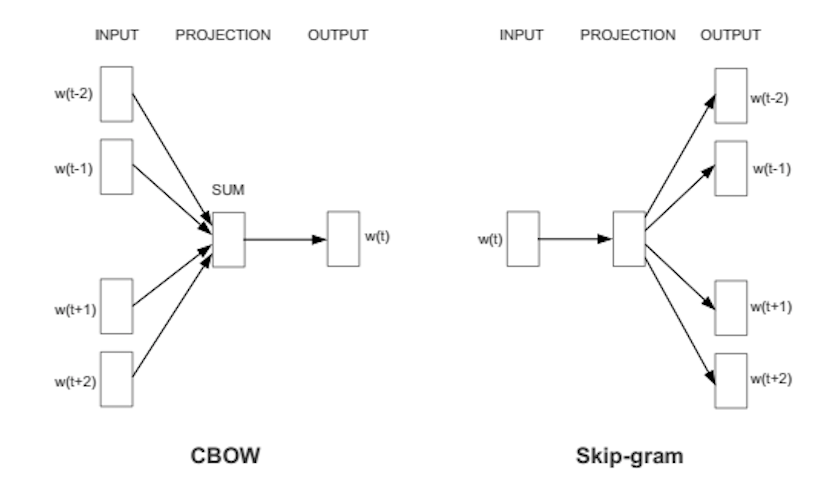

- In the **Continuous Bag-of-Words (CBoW)** architecture, the model **predicts the current word** from a window of **surrounding context** words.
- In the **Skip-gram** architecture, the model **uses current word to predict** the surrounding window of **context words**.

## Let us deep-dive into CBoW!!
- CBoW uses a **shallow feed forward neural network** with single hidden layer to produce word embeddings (vectors).
- Given a word, CBoW **uses before and after words**, called as the **context words**, to create a vector representation.

## Architecture of CBoW:

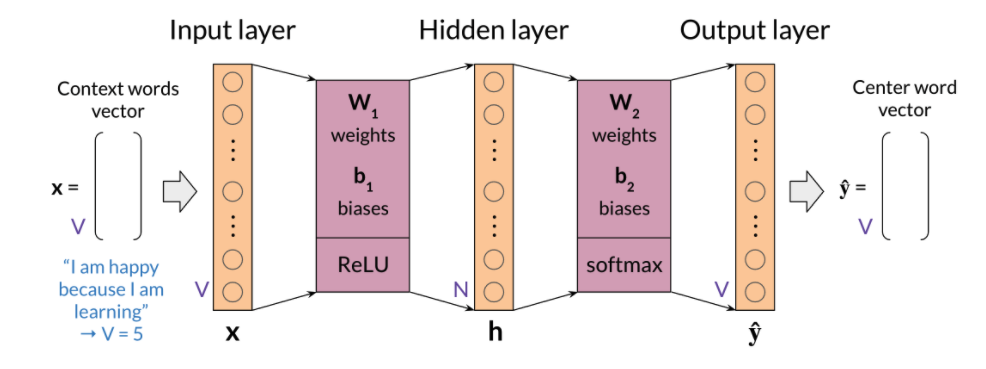

- **Input Layer**
    - Takes in **context words** as inputs.
    - Is of the size **V**, size of the vocabulary (unique words in corpus).
- **Hidden Layer**
    - Is of the size **N**, a hyper-parameter of the network that **defines the shape of word representations**.
    - **ReLU** used as the activation function.
- **Output Layer**
    - Outputs **probability** for all the words in the vocabulary.
    - Is of the size **V**, size of the vocabulary (unique words in corpus).
    - Uses **softmax** function to output probabilities.
    
## How do we generate training data for CBoW?

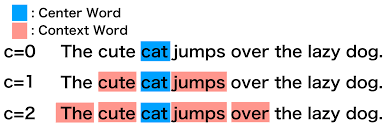

- Training data is generated by iterating through the corpus using a **sliding window** action to **define the target word and its context words**.
- The **window size** (size of the sliding window) determines the **number of before and words to consider** when predicting the target word.

## Working of CBoW
**CBoW models the problem as a multi-class classification, wherein given the context words, the model outputs the target word and in doing so learns the representation for the words.**


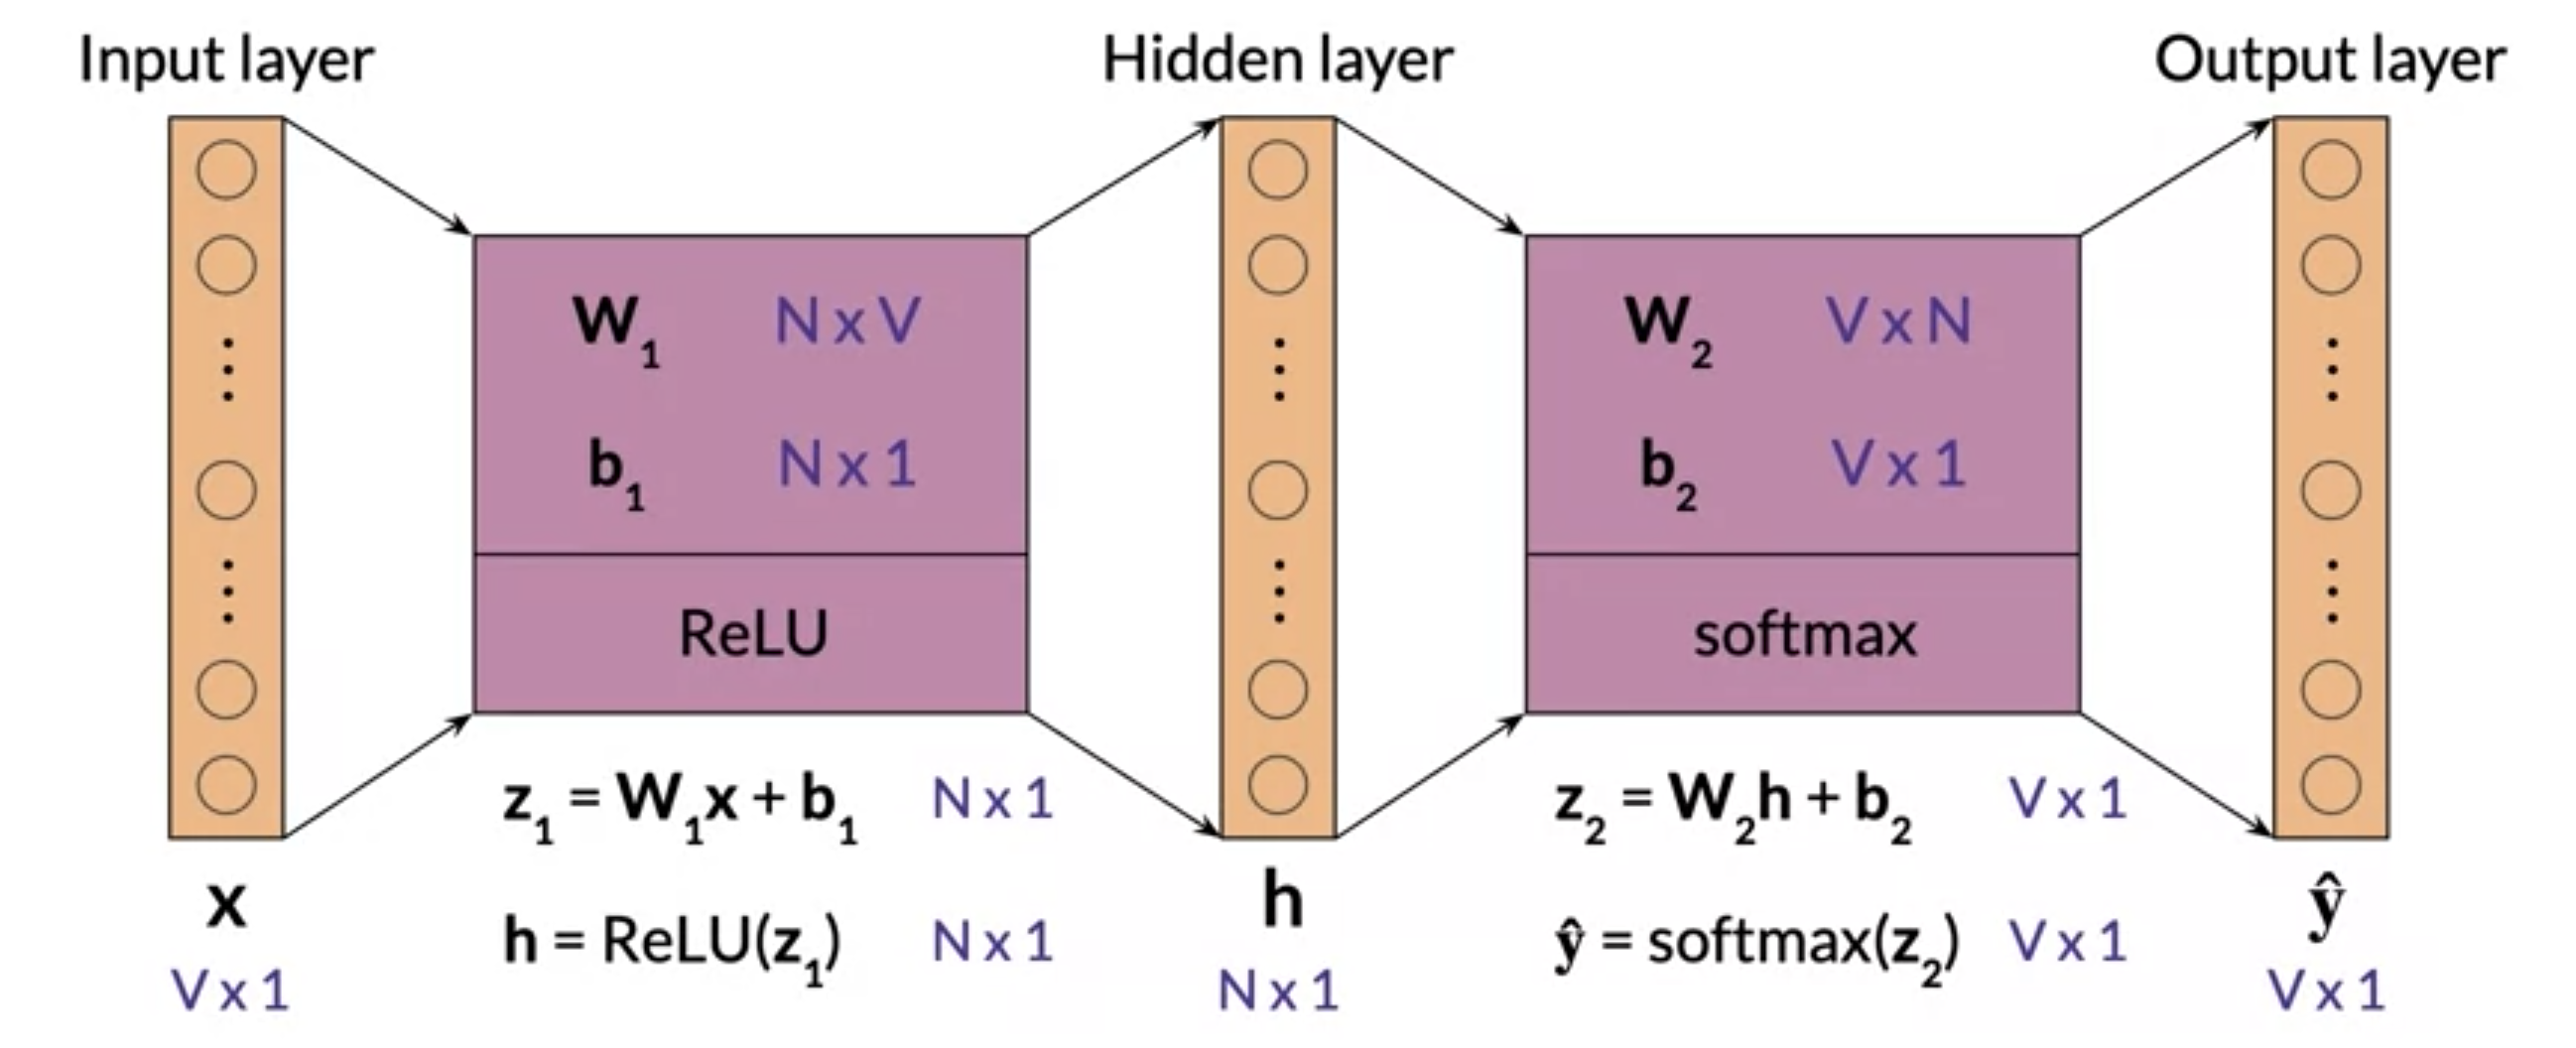

- **One-hot encoded representation** (V rows X 1 column) of the **context word/words** are sent in as input.
- Weight matrix **W$_1$** is initialized.
- Weighted sum of the inputs and the weights (W$_1$) with bias b$_1$ is **passed through ReLU activation** function to **produce output at hidden layer 'h'**.
    - Weight matrix (W$_1$) is of **shape N x V**, where N is the dimension along which we want to represent our word vectors and V is size of vocabulary.
    - z$_1$ = W$_1$x + b$_1$
    - h = ReLU(z$_1$) --> Output at hidden layer
- Similarly, weighted sum of output of hidden layer and weight matrix **W$_2$** with bias b$_2$ is **passed through softmax activation** function to produce probabilities of all words in the vocabulary.
    - The weight matrix W$_2$  takes a shape of V rows and N columns.
    - z$_2$ = W$_2$x + b$_2$
    - ŷ = softmax(z$_2$) --> Final output/prediction
- The word with the **highest probability** is considered as the model's prediction of the **target word**, i.e. **argmax(P(ŷ))**.
- The weight matrix **W$_1$** is **considered as the vector representation** of the words.


## How does the model learn the right word representations?
- CBOW uses **cross-entropy loss** as the objective function during training
  - J = -$Σ^{V}_{k=1}y_k\logŷ_{k}$
- During **back-propogation**, the network tries to **reduce this cost function**.

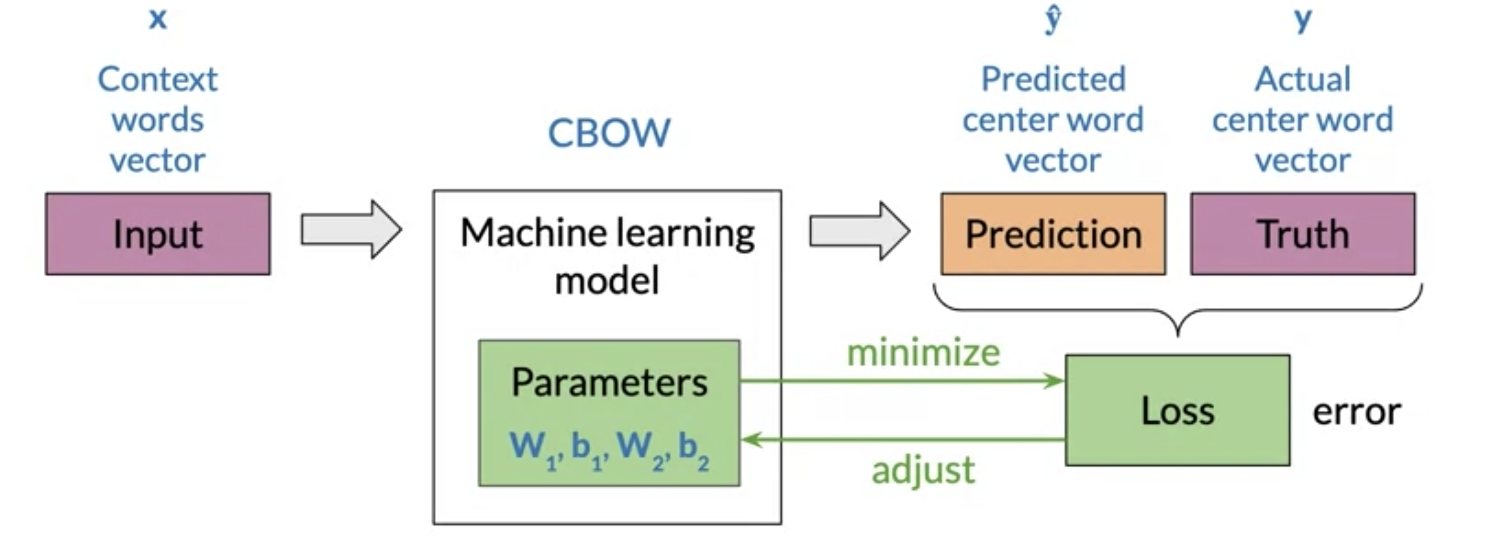

## **Generalized cost function** for batches of training examples:

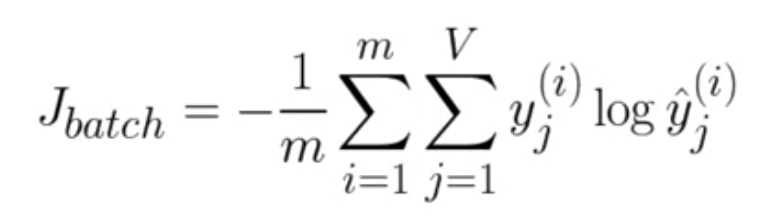

## Partial derivates of the cost function w.r.t weights and biases:



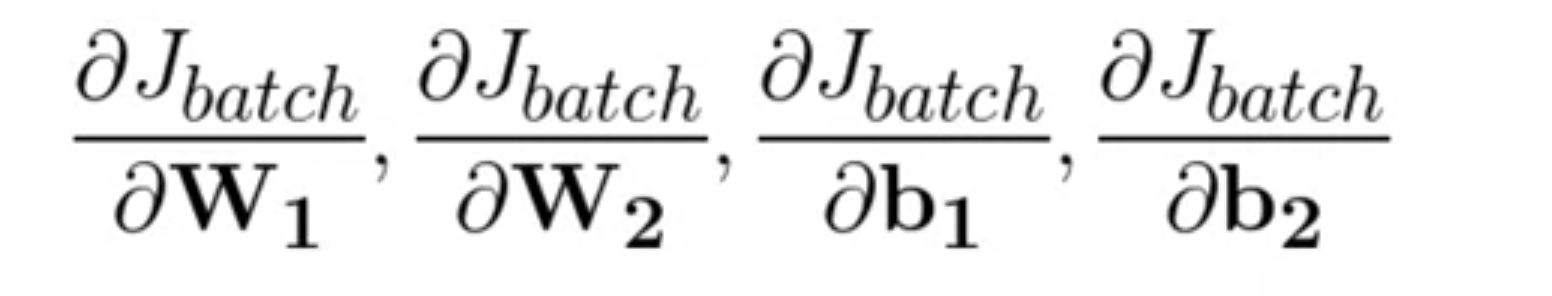

- Finally, the network parameters **W$_1$ and W$_2$ are adjusted** using gradient descent.

## Is CBoW used in practice?
- When the context window > 1, CBoW **overfits on frequent words** as the input is an average of one-hot encoded vectors of the context word.
- CBoW does **not produce good representations** for **rare words** in the corpus.

### We can over-come these dis-advantages of CBoW by using an alternative architecture of Word2Vec called the Skip-Gram.

## What is Skip-Gram?
- Skip-Gram is simply an **inversion of the CBoW** architecture.
- Takes in **input** as **center/context word** and **predict** its **surrounding words**.

## Architecture of Skip-Gram

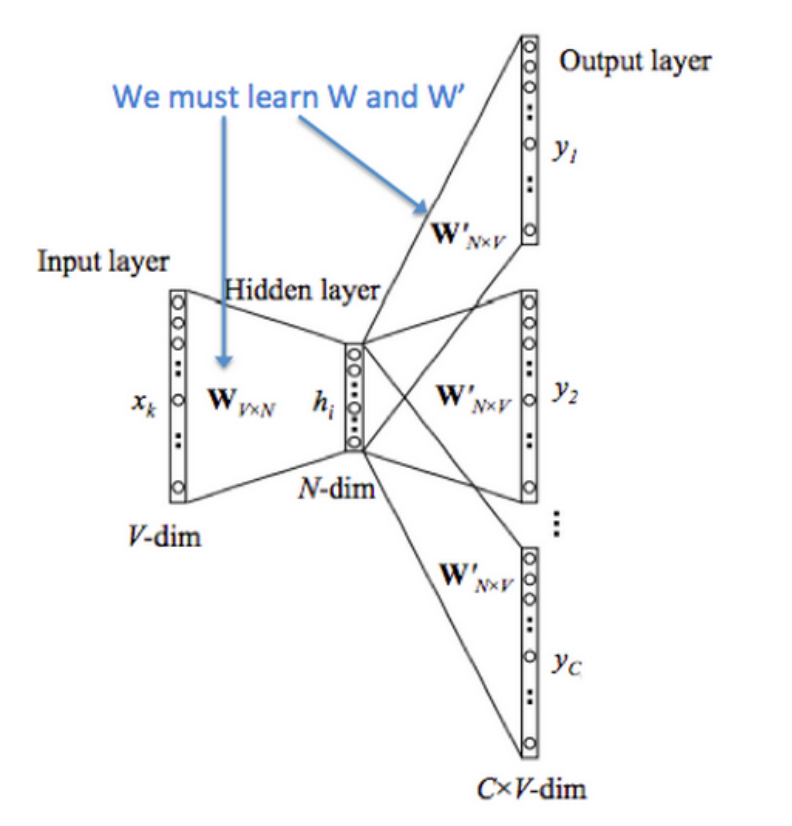

## How do we generate training examples for Skip-Gram?
- Similar to CBoW, we generate training examples by **iterating over the sentence**.
- Based on window size, **single word is chosen as input** and its **surrounding words** would be the **target**.

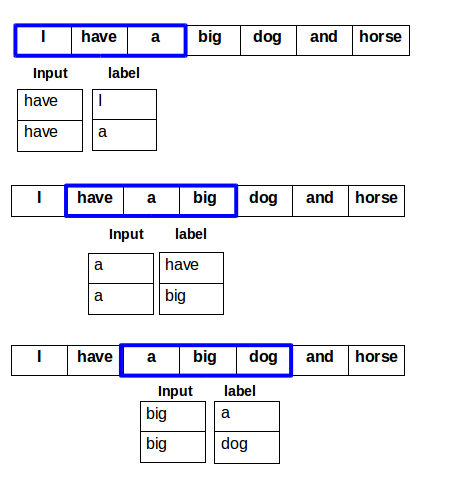

## Working of Skip-Gram
- **Input** $(x)$ is **one-hot encoded representation** of the **center word** of size |V| (vocabulary's size).
- **Weighted sum of the input** and weight matrix $W_{VxN}$ is passed on through the **hidden layer** that has linear activation.
- Output layer applies a **dot product** between the output from hidden layer **$h_{1}$  and  𝑊‘$_{N𝑥V}$** resulting in the output vector U.
- The **output vector U** is passed through **softmax activation function** to produce probabilities of observing each context word (based on window size) - $y'^{c-m}$, . . . , $y'^{c-1}$, $y'^{c+1}$, . . . , $y'^{c+m}$.

## How does Skip-Gram learn the right representations?
- **Output probabilities** are **matched** against **true probabilities**.
    - $y^{c-m}$, . , $y^{c-1}$, $y^{c+1}$, . , $y^{c+m}$, the one hot vectors of the surrounding/context words.
- Skip-Gram is trained with objective function of **log likelihood**, i.e. for given center word '$w_j$, predict context words within a fixed window of size m.


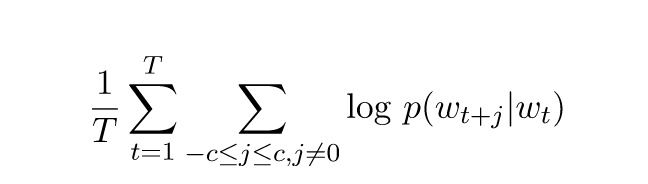

- Objective function tries to **maximize the probability** of any **context word given the current word** $w_t$.
- Model also makes a **bayesian assumption** that given the center word, all the **output words are completely independent**.
- Given the objective function, the model parameters **W and W' are fine-tuned** using gradient descent via backpropogation.
- Similar to CBoW, the **weight matrix $W_1$** is considered as the **word vector**.

## Negative Sampling for Skipgram training:
Refer: https://jalammar.github.io/illustrated-word2vec/

Playground:
https://projector.tensorflow.org/


<br>

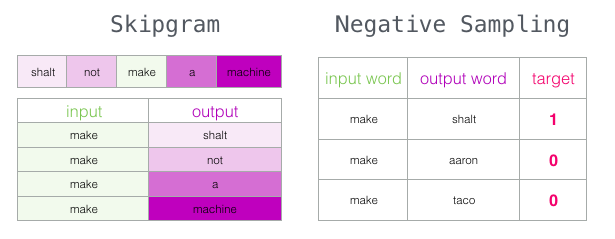

## Now that we've understood how Word2Vec can help generate meaningful and contextual word embeddings, let us get back to solving our business problem.

#### Let us focus on only features that we'd need to build the semantic search engine

In [ ]:
df_covid = pd.DataFrame(columns=['paper_id', 'title','abstract', 'doi'])
df_covid['paper_id'] = DATA.sha
df_covid['title'] = DATA.title
df_covid['abstract'] = DATA.abstract
df_covid['doi'] = DATA.doi

df_covid.head()

,paper_id,title,abstract,doi
0,fe177de29f14dd45747a3d17c2468300245b0fb4,‘I Get High With a Little Help From My Friends...,Psychoactive drugs have been central to many h...,10.3389/fpsyg.2021.719596
1,ab312eb3286e189488707ea7ac8551401a178940,Arenavirus Stable Signal Peptide Is the Keysto...,The rodent arenavirus glycoprotein complex enc...,10.1128/mbio.02063-14
2,NaN,Two-Port Fetoscopic Repair of Myelomeningocele...,OBJECTIVE The aim of this study was to assess ...,10.1159/000485655
3,NaN,Learning Curves in COVID-19: Student Strategie...,"In New Zealand, similar to the rest of the wor...",NaN
4,NaN,Glass Fragment Injury to the Craniocervical Ju...,BACKGROUND: Nonmissile penetrating injuries to...,NaN


#### We will look into the data and check if we have any null values.

In [ ]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   paper_id  35242 non-null  object
 1   title     99946 non-null  object
 2   abstract  77551 non-null  object
 3   doi       62094 non-null  object
dtypes: object(4)
memory usage: 3.1+ MB


#### Dropping duplicates

In [ ]:
df_covid.drop_duplicates(['abstract'], inplace=True)
df_covid.dropna(inplace=True)
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29458 entries, 0 to 99997
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   paper_id  29458 non-null  object
 1   title     29458 non-null  object
 2   abstract  29458 non-null  object
 3   doi       29458 non-null  object
dtypes: object(4)
memory usage: 1.1+ MB


#### We will focus on only publications in English and drop anything that is non-English.

In [ ]:
# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# loop through each text
for ii in tqdm(range(0,len(df_covid))):
    text = df_covid.iloc[ii]['abstract'].split(" ")

    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))

        except Exception as e:
            lang = "unknown"
            pass

    # Appending to language label
    languages.append(lang)

  0%|          | 0/29458 [00:00<?, ?it/s]

#### Let's look at the numbers of articles for each language.

In [ ]:
languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)

print("Total: {}\n".format(len(languages)))
print(languages_dict)

Total: 29458

{'fr': 51, 'pt': 4, 'en': 29261, 'ca': 1, 'nl': 11, 'unknown': 2, 'de': 62, 'ro': 3, 'hu': 1, 'it': 3, 'es': 59}


#### Since most of the publications are in English, we can safely drop the rest

In [ ]:
df_covid['language'] = languages
df_covid = df_covid[df_covid['language'] == 'en']
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29261 entries, 0 to 99997
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   paper_id  29261 non-null  object
 1   title     29261 non-null  object
 2   abstract  29261 non-null  object
 3   doi       29261 non-null  object
 4   language  29261 non-null  object
dtypes: object(5)
memory usage: 1.3+ MB


#### We also do not need the language feature column.

In [ ]:
df_covid = df_covid.drop(['language'], axis = 1)
df_covid.head()

,paper_id,title,abstract,doi
0,fe177de29f14dd45747a3d17c2468300245b0fb4,‘I Get High With a Little Help From My Friends...,Psychoactive drugs have been central to many h...,10.3389/fpsyg.2021.719596
1,ab312eb3286e189488707ea7ac8551401a178940,Arenavirus Stable Signal Peptide Is the Keysto...,The rodent arenavirus glycoprotein complex enc...,10.1128/mbio.02063-14
8,f9e71114eecf03cedc124d3f670b22fdf3a476b4,A rapid and quantitative assay for measuring n...,Coxsackievirus B3 (CVB3) infection has been fo...,10.1016/j.jviromet.2016.02.010
15,dc1559d0835d272fcc0c12043b27813c89251295,Burden and etiology of moderate and severe dia...,BACKGROUND: Diarrhea remains the leading cause...,10.1186/s13099-021-00428-2
17,8de77b96a986a8f94fd68b022640ba0a53b4ac50,Educating primary healthcare providers about k...,Chronic kidney disease is a major public healt...,10.1038/s41581-021-00527-y


#### Use text pre-processing techniques to get rid of punctuations and stop words

In [ ]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)

#### Creating custom list of stop-words based on our corpus

In [ ]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure',
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.',
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

#### Cleaning abstracts

In [ ]:
def pre_processor(sentence):
    mytokens = sentence.split(' ')
    mytokens = [word.lower() for word in mytokens if word not in stopwords and word not in punctuations]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

df_covid["processed_abstract"] = df_covid["abstract"].progress_apply(pre_processor)
df_covid.head()

  0%|          | 0/29261 [00:00<?, ?it/s]

,paper_id,title,abstract,doi,processed_abstract
0,fe177de29f14dd45747a3d17c2468300245b0fb4,‘I Get High With a Little Help From My Friends...,Psychoactive drugs have been central to many h...,10.3389/fpsyg.2021.719596,psychoactive drugs central human group rituals...
1,ab312eb3286e189488707ea7ac8551401a178940,Arenavirus Stable Signal Peptide Is the Keysto...,The rodent arenavirus glycoprotein complex enc...,10.1128/mbio.02063-14,the rodent arenavirus glycoprotein complex enc...
8,f9e71114eecf03cedc124d3f670b22fdf3a476b4,A rapid and quantitative assay for measuring n...,Coxsackievirus B3 (CVB3) infection has been fo...,10.1016/j.jviromet.2016.02.010,coxsackievirus b3 (cvb3) infection found accou...
15,dc1559d0835d272fcc0c12043b27813c89251295,Burden and etiology of moderate and severe dia...,BACKGROUND: Diarrhea remains the leading cause...,10.1186/s13099-021-00428-2,background: diarrhea remains leading cause chi...
17,8de77b96a986a8f94fd68b022640ba0a53b4ac50,Educating primary healthcare providers about k...,Chronic kidney disease is a major public healt...,10.1038/s41581-021-00527-y,chronic kidney disease major public health pro...


#### To train the Word2Vec model, we'll have to convert the sentences into list of words

In [ ]:
abstracts = df_covid['processed_abstract'].values

## Let us use Spacy for faster tokenization
nlp = spacy.load('en_core_web_sm', disable=["tagger", "ner"])
nlp.add_pipe('sentencizer')

def tokenize_sentences(sentence):
    sentence_corpus = []
    doc = nlp(sentence)
    sentences = [sent.text.strip() for sent in doc.sents]
    for sent in sentences:
        processed_sent_list = sent.split(" ")
        sentence_corpus.append(processed_sent_list)
    return sentence_corpus

df_covid['tokenized_abstract'] = df_covid['processed_abstract'].progress_apply(lambda x: tokenize_sentences(x))

corpus_data = df_covid['tokenized_abstract'].to_list()
word2vec_corpus = [item for items in corpus_data for item in items]

  0%|          | 0/29261 [00:00<?, ?it/s]

## Let us create our own Word2Vec model by training on our corpus

We will be using the **Skip-Gram** architecture along with **Negative Sampling** as the objective function.

## Why Negative Sampling instead of Softmax?

- **Denominator** in **softmax** is a normalizing factor **computed over entire vocabulary**.
- For large vocabulary, **softmax computation** is **highly expensive**.

We over-come the above drawbacks of softmax using **Negative-Sampling**.

- Negative-Sampling **maximizes similarity of words in the same context** and **minimize when they occur in different contexts**.
- Instead of minimizing over all words, Negative-Sampling **randomly samples handful of words (2 < k < 20)** and use them to optimize the objective.
- Each **sample** picked **(word, context)** can be **represented** as a **probability** of whether or not this pair is **near each other** in training data.


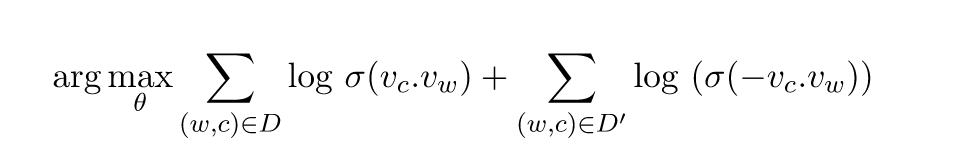

- We **optimize** over these two **probability distributions** to learn word vectors.

- **Large values of k** are chosen for **small dataset** and vice-versa.

#### Using Gensim's API to train Word2Vec

#### Parameters:
- **input** : Corpus data
- **min_count** : Ignores all words with total frequency lower than this.
- **size** : Dimensionality of the output word vectors.
- **workers** : Use these many worker threads to train the model (=faster training with multicore machines).
- **sg** : Training algorithm: 1 for skip-gram; otherwise CBOW.
- **negative** : If > 0, negative sampling will be used, the int for negative specifies how many "noise words".

In [ ]:
model = Word2Vec(word2vec_corpus, min_count=3, size= 100, workers=4, window =5, sg = 1, negative=5)

### Now that we have word embedding for our corpus, we can measure the cosine distance between the centroid of each abstract and the query to find the similarity

#### Let us calculate the centroid for each abstract using the vectors of all the words incorporating the abstract.

In [ ]:
a = [0.0]*100
df_covid["centroid"] = [a]*df_covid.shape[0]

for index, row in df_covid.iterrows():
    abstract = row['processed_abstract']
    total_sim = 0
    words = abstract.split(" ")
    centroid = np.array([0.0]*100)
    for word in words:
        try:
            b = model[word]
        except:
            continue
        centroid = np.add(centroid, b)

    df_covid.at[index,'centroid'] = centroid.tolist()

#### Let us create our base function, which when given a query will retrieve and rank documents based on similarity.

In [ ]:
def rank_docs(model, query, df_covid, num) :

    cosine_list = []

    a = []
    query = query.split(" ")
    for q in query:
        try:
            a.append(model[q])
        except:
            continue

    for index, row in df_covid.iterrows():
        centroid = row['centroid']
        total_sim = 0
        for a_i in a:
            cos_sim = np.dot(a_i, centroid)/(np.linalg.norm(a_i)*np.linalg.norm(centroid))
            total_sim += cos_sim
        cosine_list.append((row['title'], row['doi'], total_sim))


    cosine_list.sort(key=lambda x:x[2], reverse=True) ## in Descending order

    papers_list = []
    for item in cosine_list[:num]:
        papers_list.append((item[0], item[1], item[2]))
    return papers_list

#### Method to use the base function and retrieve top matching documents

In [ ]:
def query(query, top_matches=10):
    model_to_use = model
    df_covid_to_use = df_covid
    return rank_docs(model_to_use, query, df_covid_to_use, top_matches)

In [ ]:
query('origin of corona virus')

[('Role of Nonstructural Proteins in the Pathogenesis of SARS‐CoV‐2',
  '10.1002/jmv.25858',
  2.381886614774109),
 ('Re-emergence of a genetic outlier strain of equine arteritis virus: Impact on phylogeny',
  '10.1016/j.virusres.2014.12.009',
  2.3744738115509545),
 ('Emerging and Neglected Viruses of Zoonotic Importance in Croatia',
  '10.3390/pathogens10010073',
  2.370784610584278),
 ('The global emergence of severe acute respiratory syndrome coronavirus 2 in human',
  '10.1007/s13337-020-00613-y',
  2.369730359573394),
 ('An Introduction to SARS Coronavirus 2; Comparative Analysis with MERS and SARS Coronaviruses: A Brief Review',
  '10.18502/ijph.v49is1.3667',
  2.364636515916258),
 ('Virology features of a family cluster of SARS-CoV-2 infections in Shanghai, China',
  '10.1016/j.bsheal.2021.05.003',
  2.3634767705386515),
 ('Canine Distemper Spillover in Domestic Dogs from Urban Wildlife',
  '10.1016/j.cvsm.2011.08.005',
  2.3596838753219522),
 ('Next-Generation Sequencing for P

## Conclusion


- **Continous text representations** are used to **capture syntactic and semantic similarity** that, **discrete text representations dont** capture.
- **SVD** based methods **suffer from scaling** and in practice, iterative method like Word2Vec is used.
- **Word2Vec** models the data as multi-class classification problem and in doing so, **learns the word representations**.
- Two architectures of Word2Vec - (i) **CBoW** and (ii) **Skip-Gram**.
- Training methods available - (i) **Negative Sampling** and (ii) **Hierarchical Softmax**
- **Gensim** library is used for building Word2Vec from scratch.
- Finally, we **built** a **search engine** based on **semantic similarity between query and abstracts** of the publications.

## Post Read


### 1. Hierarchical Softmax:

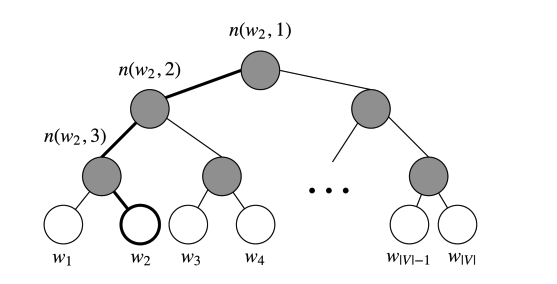

- Another training method to overcome the computation expense of softmax.
- Uses binary tree to construct vocabulary and leaves are the words.
- Each node of the graph is associated to a vector, which the model will have to learn.
- The probability of a word 'w' is equal to the probability of a random walk starting in the root and ending in leaf node corresponding to 'w'.
- With a goal to maximize likelihood (or minimize negative log-likelihood), in hierarchical softmax, the vectors of the nodes in the tree are updated that are in path from root to leaf node.


### 2. How are the weights adjusted in Word2Vec?:
- [Adjusting Weight Parameters](https://thinkinfi.com/continuous-bag-of-words-cbow-single-word-model-how-it-works/)    

### 3. Enhancements over Word2Vec
- [Introduction to GloVe](https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010)
- [Introduction to FastText](https://amitness.com/2020/06/fasttext-embeddings/)


